In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from utils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="7" 

In [2]:
strategy = tf.distribute.MirroredStrategy()
print(tf.__version__)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
2.3.1


In [3]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
plot_root = 'plots/'
train_sets = ['x10_reads.fa']
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']

In [4]:
df = read_fasta(train_root + train_sets[0])
train_reads = np.array(seqs2onehot(np.array(df.seqs)), dtype='float')
train_reads = np.expand_dims(train_reads, -1)
train_reads.shape

(169538, 150, 4, 1)

In [5]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1]))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            rec = decoder(z)
            
            rec_loss = K.sum(K.categorical_crossentropy(tf.squeeze(data), rec), 1)
            kl_loss = 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1. - z_log_var, axis=1)
            print(rec_loss[0], kl_loss[0])
            total_loss = rec_loss + kl_loss
            total_loss = tf.reduce_mean(total_loss)
            rec_loss = tf.reduce_mean(rec_loss)
            kl_loss = tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": rec_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [23]:
ckpt_num = 'vanilla_vae'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))
    
input_size = (150,4)
epochs = 500
batch_size = 512
callback = EarlyStopping(monitor='kl_loss', patience=15)

In [24]:
y_true = np.array([[[0, 1, 0], [0, 0, 1]],[[0, 1, 0], [0, 0, 1]]], dtype='float')
y_pred = np.array([[[0.05, 0.95, 0], [0.1, 0.8, 0.1]],[[0.05, 0.95, 0], [0.1, 0.8, 0.1]]])
print(y_true.shape)
K.categorical_crossentropy(y_true, y_pred)#, K.sum(K.categorical_crossentropy(y_true[0], y_pred[0]), 1)

(2, 2, 3)


<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[0.05129329, 2.30258509],
       [0.05129329, 2.30258509]])>

In [35]:
K.clear_session()
with strategy.scope():
    for width in [2048]:
        for latent_dim in [256]: #600
            hist_path = os.path.join(model_root, ckpt_num, 'seq_'+str(latent_dim))
            encoder_inputs = keras.Input(shape=input_size)
            x = Flatten()(encoder_inputs)
            x = Dense(width*4, activation="relu")(x)
            z_mean = Dense(latent_dim, name="z_mean")(x)
            z_log_var = Dense(latent_dim, name="z_log_var")(x)
            z = Sampling()([z_mean, z_log_var])
            encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
            print(encoder.summary())

            latent_inputs = keras.Input(shape=(latent_dim,))
            x = Dense(4 * width, activation="relu")(latent_inputs)
            x = Dense(600)(x)
            x = Reshape((150, 4))(x)
            decoder_outputs = tf.keras.activations.softmax(x, axis=-1)
            decoder = Model([latent_inputs], decoder_outputs, name="decoder")
            print(decoder.summary())

            vae = VAE(encoder, decoder)
            vae.compile(optimizer=keras.optimizers.Adam(0.0005), run_eagerly=False)
            history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)#, callbacks=[callback])
#             with open(hist_path, 'wb') as f:
#                 pickle.dump(history.history, f)


#             fig, ax1 = plt.subplots()
#             ax1.plot(history.history['reconstruction_loss'], color='green')
#             ax1.plot(history.history['loss'], color='red')
#             ax2 = ax1.twinx()
#             ax2.plot(history.history['kl_loss'])
#             plot_path = os.path.join(plot_root, 'seq_'+str(latent_dim)+'_loss''.png')
#             plt.savefig(plot_path)

#             easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
#             test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
#             test_reads_1 = np.delete(test_reads_1, 3, axis=2)
#             test_reads_1 = test_reads_1.reshape(test_reads_1.shape[0], test_reads_1.shape[1]*test_reads_1.shape[2])
#             r1 = vae.predict(test_reads_1, verbose=1)
#             pred = keras.losses.binary_crossentropy(test_reads_1, r1)
#             auc = metrics.roc_auc_score(np.array(easy_1.viral), np.array(pred))

#             model_path = os.path.join(model_root, ckpt_num, 'seq_'+str(latent_dim)+'_'+str(auc))
#             vae.save(model_path, save_format='tf')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 4)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 600)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 8192)         4923392     flatten[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 256)          2097408     dense[0][0]                      
____________________________________________________________________________________________

332/332 [==============================] - 8s 25ms/step - loss: 205.1243 - reconstruction_loss: 201.8782 - kl_loss: 3.2460
Epoch 5/500
332/332 [==============================] - 8s 25ms/step - loss: 204.6791 - reconstruction_loss: 200.9560 - kl_loss: 3.7230
Epoch 6/500
332/332 [==============================] - 8s 25ms/step - loss: 204.6482 - reconstruction_loss: 200.6913 - kl_loss: 3.9569
Epoch 7/500
267/332 [=======================>......] - ETA: 1s - loss: 204.5373 - reconstruction_loss: 200.3944 - kl_loss: 4.1429

KeyboardInterrupt: 

In [ ]:
# vae = load_model('models/vanilla_vae/seq_128_0.5060172552560805')

In [26]:
easy_1 = assign_labels(read_fasta(test_root + test_sets[0]))
test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)), dtype='float')
test_reads_1 = np.expand_dims(test_reads_1, -1)
z_mean, z_log_var, z = vae.encoder.predict(test_reads_1, verbose=1)
reconstruction = vae.decoder(z)

(105492, 2)


In [32]:
pos = easy_1.viral==1
neg = easy_1.viral==0
# print(reconstruction.astype('float64').dtype)
# reconstruction_loss = K.sum(K.categorical_crossentropy(tf.squeeze(test_reads_1), reconstruction), 1)
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5*tf.reduce_sum(kl_loss, 1)
# pos_samples = (np.array(reconstruction_loss + kl_loss)[pos], np.array(reconstruction_loss)[pos], np.array(kl_loss)[pos])
# neg_samples = (np.array(reconstruction_loss + kl_loss)[neg], np.array(reconstruction_loss)[neg], np.array(kl_loss)[neg])

In [33]:
kl_loss

<tf.Tensor: shape=(105492,), dtype=float32, numpy=
array([0.66485995, 0.03946617, 0.20305285, ..., 1.8214705 , 0.05897623,
       0.04019967], dtype=float32)>

Positive samples


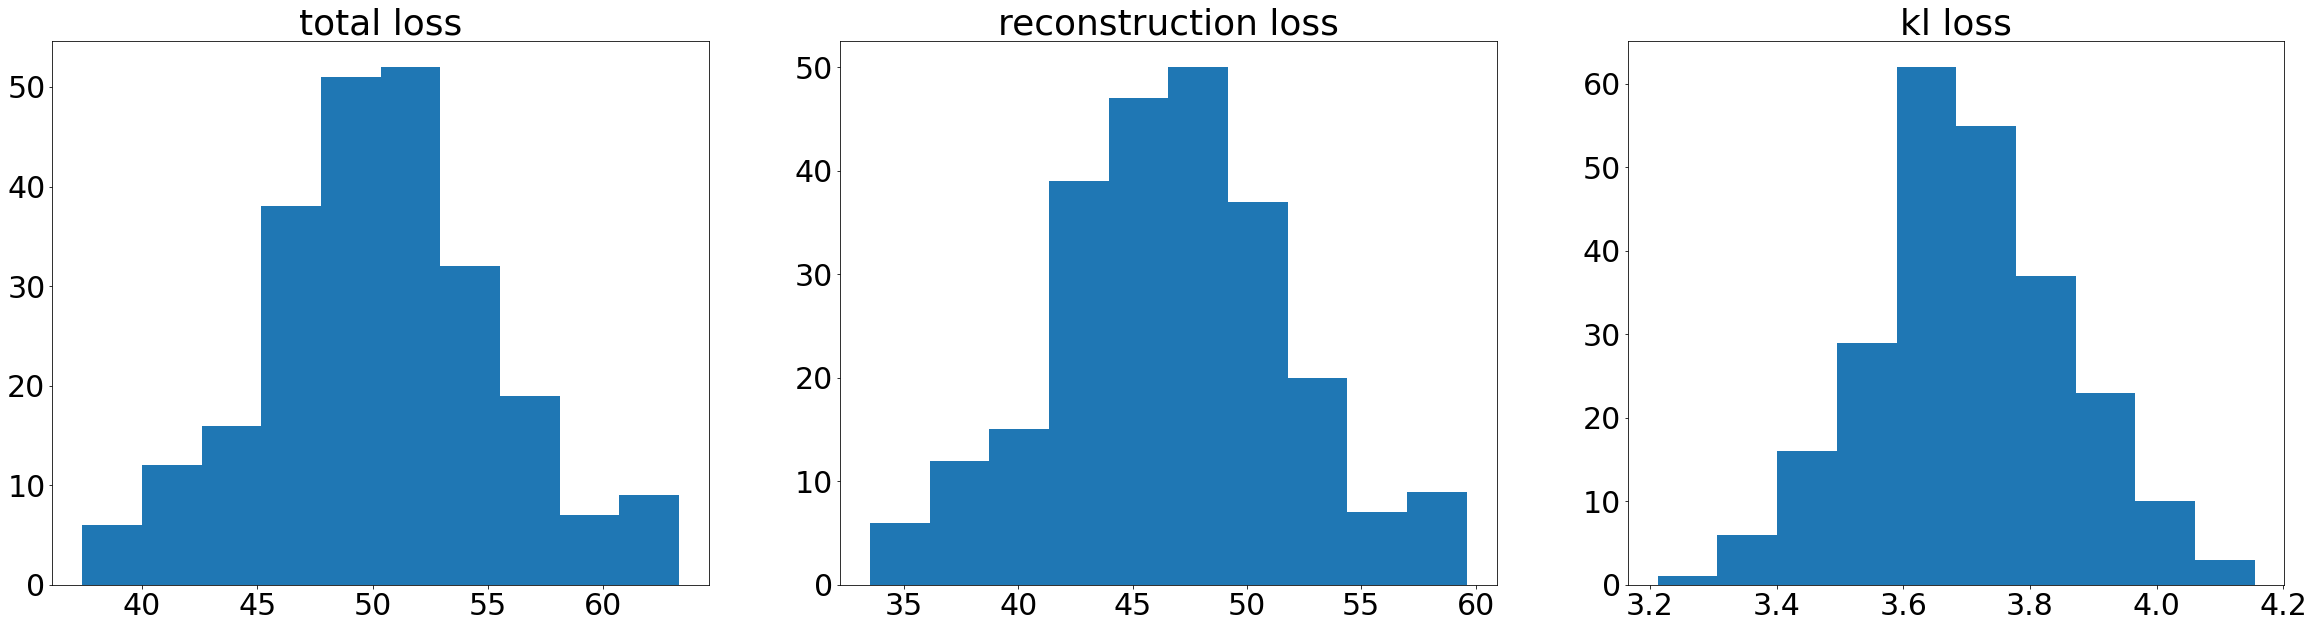

Negative samples


Text(0.5, 1.0, 'kl loss')

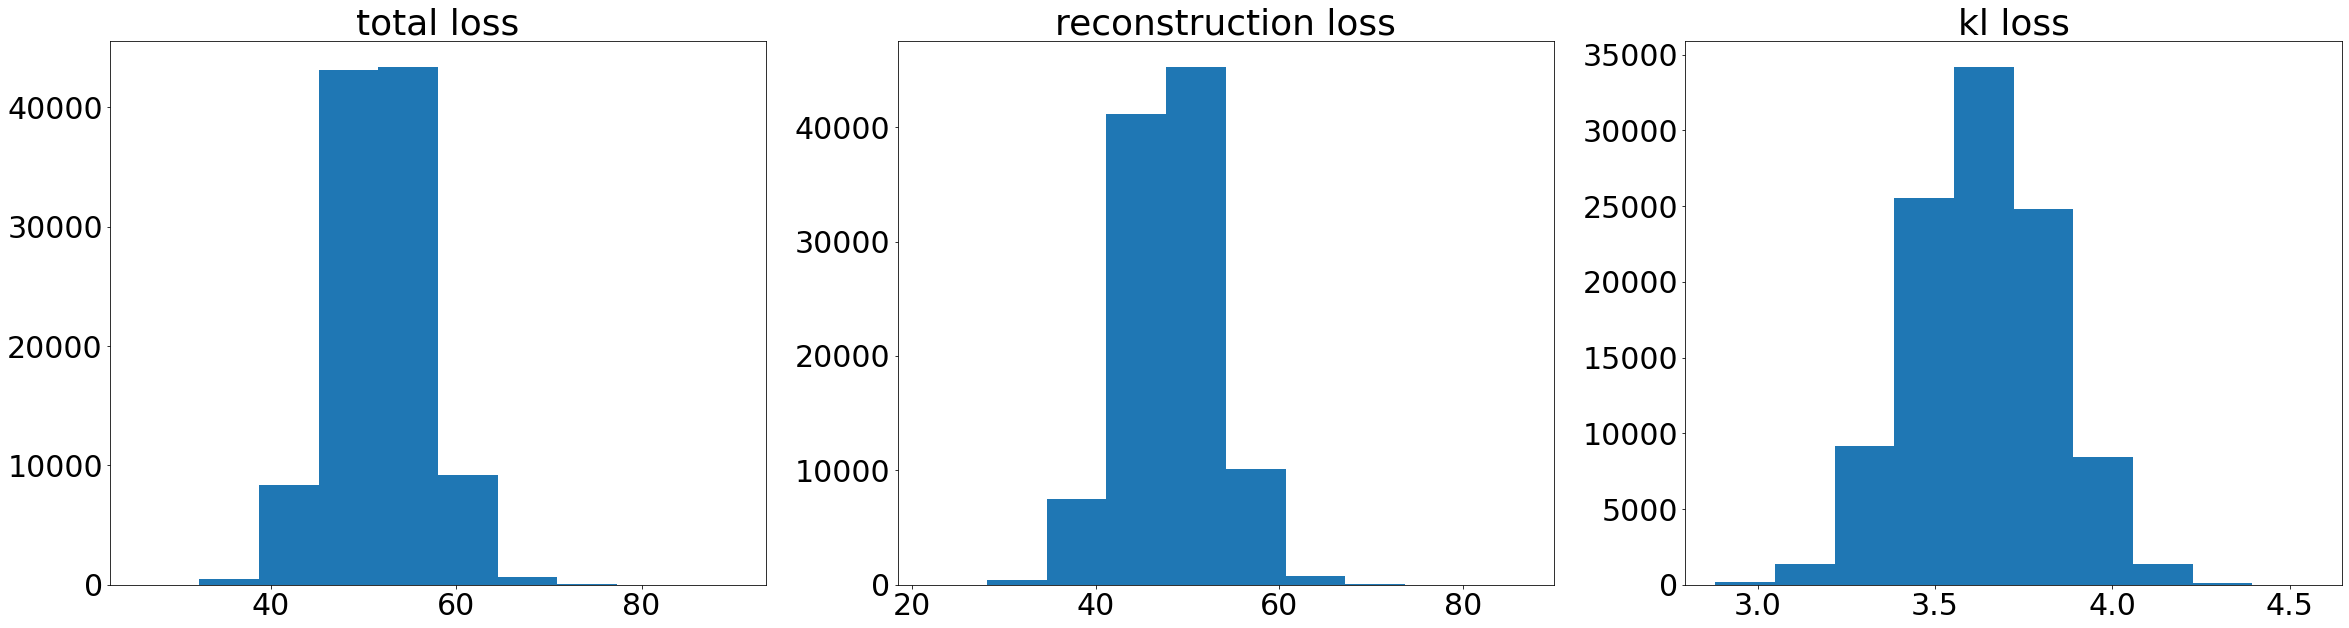

In [58]:
print('Positive samples')
plt.rcParams["font.size"] = "30"
fig, ax = plt.subplots(1,3, figsize=(40,10))
n, bins, patches = ax[0].hist(pos_samples[0]); ax[0].set_title('total loss')
n, bins, patches = ax[1].hist(pos_samples[1]); ax[1].set_title('reconstruction loss')
n, bins, patches = ax[2].hist(pos_samples[2]); ax[2].set_title('kl loss')
plt.show()
print('Negative samples')
fig, ax = plt.subplots(1,3, figsize=(40,10))
n, bins, patches = ax[0].hist(neg_samples[0]); ax[0].set_title('total loss')
n, bins, patches = ax[1].hist(neg_samples[1]); ax[1].set_title('reconstruction loss')
n, bins, patches = ax[2].hist(neg_samples[2]); ax[2].set_title('kl loss')